# Homework - 05

In [2]:
# Standard library imports
import json
import warnings

# Third-party imports
import pandas as pd
import psycopg
import requests
from joblib import dump
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# Evidently imports
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

# Suppress warnings
warnings.filterwarnings("ignore")

## Q1 Prepare the dataset

Start with `baseline_model_nyc_taxi_data.ipynb`. Download the March 2024 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

* 72044
* 78537 
* 57457 ✅
* 54396

In [4]:
mkdir data

In [5]:
files = [("green_tripdata_2024-03.parquet", "./data")]

print("Download files:")
for file, path in files:
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp = requests.get(url, stream=True)
    save_path = f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(
            resp.iter_content(),
            desc=f"{file}",
            postfix=f"save to {save_path}",
            total=int(resp.headers["Content-Length"]),
        ):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:02<00:00, 532946.37it/s, save to ./data/green_tripdata_2024-03.parquet]


In [6]:
march_2024 = pd.read_parquet("./data/green_tripdata_2024-03.parquet")

print(f"shape of march_2024: {march_2024.shape}")

march_2024.head()

shape of march_2024: (57457, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-03-01 00:10:52,2024-03-01 00:26:12,N,1.0,129,226,1.0,1.72,12.8,1.0,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00
1,2,2024-03-01 00:22:21,2024-03-01 00:35:15,N,1.0,130,218,1.0,3.25,17.7,1.0,0.5,0.00,0.0,NaN,1.0,20.20,2.0,1.0,0.00
2,2,2024-03-01 00:45:27,2024-03-01 01:04:32,N,1.0,255,107,2.0,4.58,23.3,1.0,0.5,3.50,0.0,NaN,1.0,32.05,1.0,1.0,2.75
3,1,2024-03-01 00:02:00,2024-03-01 00:23:45,N,1.0,181,71,1.0,0.00,22.5,0.0,1.5,0.00,0.0,NaN,1.0,24.00,1.0,1.0,0.00
4,2,2024-03-01 00:16:45,2024-03-01 00:23:25,N,1.0,95,135,1.0,1.15,8.6,1.0,0.5,1.00,0.0,NaN,1.0,12.10,1.0,1.0,0.00


### Baseline model for batch monitoring

In [7]:
# create target
march_2024["duration_min"] = (
    march_2024.lpep_dropoff_datetime - march_2024.lpep_pickup_datetime
)
march_2024.duration_min = march_2024.duration_min.apply(
    lambda td: float(td.total_seconds()) / 60
)

In [8]:
print(f" Before filtering, shape of march_2024: {march_2024.shape}")

# filter out outliers
march_2024 = march_2024[
    (march_2024.duration_min >= 0) & (march_2024.duration_min <= 60)
]
march_2024 = march_2024[
    (march_2024.passenger_count > 0) & (march_2024.passenger_count <= 8)
]

print(f" After filtering, shape of march_2024: {march_2024.shape}")

 Before filtering, shape of march_2024: (57457, 21)
 After filtering, shape of march_2024: (54135, 21)


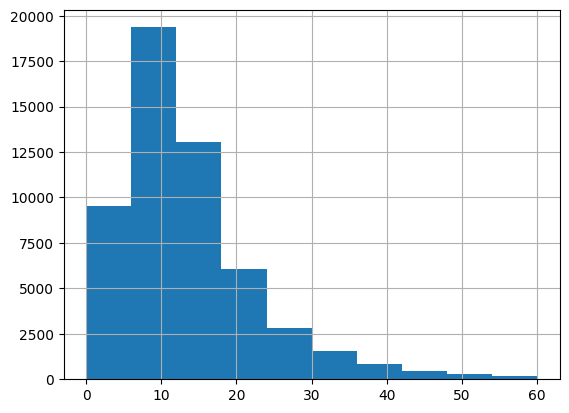

In [9]:
march_2024["duration_min"].hist();

In [10]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [11]:
train_data = march_2024[:30000]
val_data = march_2024[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data["prediction"] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data["prediction"] = val_preds

In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.772473239359445
3.7168145679293665


### Dump model and reference data

In [17]:
!mkdir models

In [18]:
with open("models/lin_reg.bin", "wb") as f_out:
    dump(model, f_out)

In [19]:
val_data.to_parquet("data/reference.parquet")

## Q2 Metric
Let's expand the number of data quality metrics we’d like to monitor! Please add one metric of your choice and a quantile value for the "fare_amount" column (quantile=0.5).

Hint: 
    Using newer version: from evidently.metrics.column_statistics import QuantileValue, ValueDrift

What metric did you choose?

In [20]:
data_definition = DataDefinition(
    numerical_columns=num_features + ["prediction"], categorical_columns=cat_features
)

train_dataset = Dataset.from_pandas(train_data, data_definition)

val_dataset = Dataset.from_pandas(val_data, data_definition)

NameError: name 'DataDefinition' is not defined

In [ ]:
report = Report(
    metrics=[
        QuantileValue(column="fare_amount", quantile=0.5),
        ValueDrift(column="prediction"),
    ],
    include_tests=True,
)

In [ ]:
snapshot = report.run(reference_data=train_dataset, current_data=val_dataset)

snapshot

In [ ]:
result = snapshot.dict()

print("Quantile value for fare_amount:", result["metrics"][0]["value"])
print("Value drift for prediction:", round(result["metrics"][1]["value"], 5))

# Q3. Monitoring
Let’s start monitoring. Run expanded monitoring for a new batch of data (March 2024).

What is the maximum value of metric quantile = 0.5 on the "fare_amount" column during March 2024 (calculated daily)?

- 10
- 12.5
- 14.2 ✅
- 14.8

In [ ]:
CONNECTION_STRING = "host=localhost port=5432 user=postgres password=example"
CONNECTION_STRING_DB = CONNECTION_STRING + " dbname=test"

conn = psycopg.connect(CONNECTION_STRING_DB)

with conn.cursor() as curr:
    curr.execute("""
             SELECT * FROM dummy_metrics
             """)

    data = curr.fetchall()

    # calculate the max of the fare_amount column
    df = pd.DataFrame(data, columns=["id", "fare_amount", "created_at"])
    max_fare_amount = df["fare_amount"].max()

# print the max fare_amount
print("Max fare_amount:", max_fare_amount)


# Q4  Dashboard

Finally, let’s add panels with new added metrics to the dashboard. After we customize the dashboard let's save a dashboard config, so that we can access it later. Hint: click on “Save dashboard” to access JSON configuration of the dashboard. This configuration should be saved locally.

Where to place a dashboard config file?

- project_folder (05-monitoring)
- project_folder/config (05-monitoring/config)
- project_folder/dashboards (05-monitoring/dashboards) ✅
- project_folder/data (05-monitoring/data)

In [ ]:
with open("./dashboards/data_drift.json", "r") as f:
    dashboard_config = json.load(f)

# print the configuration
print(json.dumps(dashboard_config, indent=2))